In [1]:
# %%bash
# conda info| grep "active environment"

     active environment : abg


# Bin Packing Examples

* Im putting up this notebook just in case it becomes useful to someone. I looked into bin packing because Im always annoyed at how much blank space appears whenever I look at datasets. 

At first I looked at https://github.com/secnot/rectpack because python is easy to get up and test something. But I found it dreadfully slow. As an example, a 397 image dataset (https://www.kaggle.com/ajayrana/hymenoptera-data#hymenoptera_data.zip) took minutes to compute, too slow.

So I looked into https://github.com/juj/RectangleBinPack, upon which this is mostly based. That promised to be faster and indeed it is, but it is built using boost njam, and I find that cumbersome, also, to store tests I like jupyter, so I added python bindings using pybind11. I only tested this with linux 16 and 18 python 3.6 and 3.7, but with these setups on a virgin conda environment (virtual env or docker should be similar), with gcc and cmake installed in my computer all one has to do is run the install.sh.

I also wrapped the bin packing classes so that all heuristics therein contained can be ran out of one command. The processing time was reduced from minutes to miliseconds. 

* To see how the various algorithms deal with sequential information I did a hue sorting of the images.
* Efficiency is not logged, however for fair comparison, all bins are initialized with a square area which is 110% the total area covered by the sum of all rectangles; the number of rectangles that dont fit in this area is logged. The display however crops the image to the used area so maybe I should log that.

#### Caveats and Furthermores
* This notebook also uses a private module I use which isnt ready to see the light of day, yet. However if you do run this notebook without the dataset, it should work after installing the **pybinpack** module.


* I have not read all the literature, or have thought or read about if there is a closed form bin packing optimal solution. Therefore take this all with a grain of salt. 


* After looking at all these algorithms I see that theres probably many opportunities to improve the packing such as:
    * looking a back into empty spaces, 
    * using some form of multigrid simulation; maybe in 4d to allow intersticial spaces to be packed?
    * I would suspect that shortly -if not yet already- someone will have implementing a deeplearning binpacker that improves efficiency.


xvdp 2018.12


### Necessary included - these should have been all installed by the ./install.sh bash

In [2]:
import sys
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

import pybinpack as pb
print('python', sys.version_info[:3])
print('pybinpack', pb.__version__, '\n', pb.__file__)

python (3, 6, 5)
pybinpack 0.0.1 
 /home/z/miniconda3/envs/abg/lib/python3.6/site-packages/pybinpack-_0.0.2_-py3.6-linux-x86_64.egg/pybinpack.cpython-36m-x86_64-linux-gnu.so


### Optional include replaced by array in the except

In [3]:
try:
    # if this fails, is that I havent released xun yet, this notebook can works just with filesizes
    import xun
    print('xun', xun.__version__)

    data_root = '/home/z/data/hymenoptera_data'
    #data_split = (-1, 25, 25)
    force = False;#True # set to true to reevaluate the statistics of dataset
    H = xun.dataset.Stats(data_root=data_root, force=force)
    
    sort = 'hue'
    files = H.files_sorted(sort)
    sizelist = H.sizes[H.sorted[sort]]
    print(sizes.tolist())
    
except:
    print("if xun not installed, sizelist suffices, no images will be shown but op still works")
    sizelist = [[332, 500], [500, 333], [333, 500], [375, 500], [353, 500], [333, 500], [333, 500], [500, 333], [333, 500], [500, 441], [334, 500], [359, 479], [333, 500], [500, 375], [333, 500], [432, 500], [400, 500], [384, 500], [388, 500], [333, 500], [361, 500], [333, 500], [375, 500], [137, 200], [434, 500], [356, 500], [500, 399], [423, 500], [500, 488], [392, 500], [382, 500], [1944, 2592], [500, 444], [468, 435], [323, 400], [500, 464], [321, 500], [377, 500], [351, 500], [358, 500], [173, 500], [334, 500], [477, 500], [333, 500], [361, 500], [333, 500], [375, 500], [500, 500], [146, 500], [333, 500], [333, 500], [500, 500], [534, 800], [333, 500], [375, 500], [500, 415], [375, 500], [500, 500], [484, 500], [375, 500], [318, 500], [375, 500], [333, 500], [642, 812], [429, 486], [333, 500], [333, 500], [375, 500], [333, 500], [409, 500], [310, 500], [375, 500], [375, 500], [375, 500], [434, 500], [375, 500], [500, 333], [375, 500], [445, 600], [436, 500], [333, 500], [1984, 1488], [500, 366], [447, 500], [313, 500], [333, 500], [332, 500], [314, 500], [500, 333], [451, 500], [329, 500], [375, 500], [334, 500], [500, 422], [444, 500], [409, 500], [375, 500], [333, 500], [375, 500], [368, 500], [333, 500], [375, 500], [333, 500], [487, 500], [345, 500], [348, 500], [338, 500], [256, 300], [500, 500], [479, 500], [375, 500], [371, 500], [500, 382], [366, 500], [375, 500], [333, 500], [236, 500], [407, 500], [500, 474], [272, 500], [369, 500], [464, 500], [282, 500], [345, 500], [333, 500], [374, 500], [374, 500], [400, 500], [334, 500], [500, 383], [333, 500], [333, 500], [333, 500], [500, 375], [333, 500], [333, 500], [333, 500], [330, 500], [470, 500], [375, 500], [333, 500], [397, 500], [441, 500], [500, 411], [372, 500], [375, 500], [291, 500], [500, 375], [333, 500], [333, 500], [375, 500], [333, 500], [333, 500], [500, 375], [334, 500], [500, 470], [333, 500], [466, 500], [289, 500], [375, 500], [375, 500], [375, 500], [500, 494], [333, 500], [500, 499], [375, 500], [500, 369], [333, 500], [316, 500], [381, 500], [333, 500], [375, 500], [333, 500], [375, 500], [484, 500], [500, 475], [375, 500], [375, 500], [400, 500], [334, 500], [239, 500], [375, 500], [300, 399], [333, 500], [485, 500], [414, 500], [375, 500], [375, 500], [379, 500], [352, 500], [500, 357], [333, 500], [361, 500], [407, 500], [375, 500], [412, 500], [333, 500], [411, 500], [377, 500], [363, 500], [305, 500], [334, 500], [534, 800], [325, 500], [333, 500], [375, 500], [410, 500], [333, 500], [500, 455], [387, 311], [375, 500], [313, 500], [322, 500], [333, 500], [426, 500], [333, 500], [375, 500], [500, 337], [375, 500], [374, 500], [375, 500], [500, 311], [432, 500], [500, 375], [500, 458], [332, 500], [500, 444], [333, 500], [500, 500], [376, 500], [375, 500], [333, 500], [365, 500], [411, 500], [500, 487], [533, 800], [494, 500], [375, 500], [374, 500], [355, 500], [333, 500], [333, 500], [375, 500], [500, 367], [375, 500], [334, 500], [500, 409], [335, 500], [500, 441], [500, 486], [333, 500], [379, 500], [333, 500], [362, 500], [500, 333], [372, 500], [333, 500], [328, 500], [333, 500], [478, 500], [500, 375], [500, 404], [500, 500], [500, 375], [333, 500], [333, 500], [375, 500], [366, 500], [356, 500], [423, 500], [333, 500], [319, 500], [333, 500], [352, 500], [375, 500], [333, 500], [450, 500], [468, 500], [352, 500], [375, 500], [333, 500], [333, 500], [458, 500], [402, 500], [430, 500], [333, 500], [500, 375], [333, 500], [333, 500], [500, 468], [375, 500], [199, 500], [371, 500], [409, 500], [333, 500], [332, 500], [400, 500], [462, 500], [500, 375], [335, 500], [375, 500], [375, 500], [333, 500], [500, 500], [333, 500], [462, 400], [375, 500], [375, 500], [369, 500], [375, 500], [705, 646], [375, 500], [375, 500], [375, 500], [500, 394], [339, 500], [405, 500], [375, 500], [500, 500], [261, 280], [333, 499], [357, 500], [500, 333], [375, 500], [130, 193], [338, 449], [238, 320], [496, 343], [374, 500], [400, 500], [160, 200], [344, 500], [500, 375], [375, 500], [396, 500], [375, 500], [375, 500], [500, 348], [236, 343], [375, 500], [375, 500], [375, 500], [181, 500], [375, 500], [375, 500], [292, 500], [333, 500], [376, 500], [512, 768], [500, 417], [375, 500], [415, 500], [387, 500], [500, 333], [370, 500], [333, 500], [375, 500], [375, 500], [374, 500], [500, 328], [333, 500], [500, 333], [400, 500], [375, 500], [333, 500], [375, 500], [366, 500], [492, 500], [333, 500], [272, 199], [375, 500], [270, 360], [482, 500], [333, 500], [500, 417], [250, 351], [333, 500], [357, 500], [334, 500], [375, 500], [334, 500], [364, 500], [333, 500], [362, 500], [332, 500], [375, 500], [333, 500], [343, 500], [376, 500], [419, 500], [333, 500], [375, 500], [333, 500], [446, 500], [334, 500], [332, 500], [364, 500]]

xun 0.0.3.4
mean [0.51739331 0.4775178  0.35165982]
std [0.22529352 0.21524028 0.2138967 ]
meansz 441
minsz 130
maxsz 2592
bpp_range [24 24]
hue 397
rgb_means 397
sat 397
siz 397
sizes 397
std 397
stds 397
val 397
Loaded statistics from
 /home/z/data/hymenoptera_data/stats.json
 /home/z/data/hymenoptera_data/stats.hdf5
 /home/z/data/hymenoptera_data/file_list.txt
if xun not installed, sizelist suffices, no images will be shown but op still works


/home/z/miniconda3/envs/abg/lib/python3.6/site-packages/networkx/drawing/nx_pydot.py:27: UserWarning: Module pybinpack was already imported from /home/z/miniconda3/envs/abg/lib/python3.6/site-packages/pybinpack-_0.0.2_-py3.6-linux-x86_64.egg/pybinpack.cpython-36m-x86_64-linux-gnu.so, but /home/z/work/compile_sketch/pybinpack is being added to sys.path
  from pkg_resources import parse_version


### Display code

In [4]:
def pack_to_canvas(pack):
    """
        combined with pybinpack.Binnit
        reshape output of Binnit::pack, get size of bin
    """
    repacked = pack.reshape(-1, 3, 2)
    posmax = (repacked[:, 1] + repacked[:, 2]).max(axis=0)
    return repacked, posmax
    
def displaybin(repacked, posmax, file_list=[], figsize=(20,8)):
    fig, ax = plt.subplots(1,2)
    plt.rcParams["figure.figsize"] = figsize
    
    _r = Rectangle((0, 0), posmax[1], posmax[0], facecolor='none', alpha=1, edgecolor='k')
    ax[0].add_patch(_r)
    for i, r in enumerate(repacked):
        index = r[0][1]
        pos = np.roll(r[1], 1)
        area = np.roll(r[2], 1)
        rect = Rectangle(pos, area[0], area[1], facecolor='r', alpha=0.5, edgecolor='k')
        ax[0].add_patch(rect)
        
    ax[0].set_ylim(-10, posmax[1]+10)
    ax[0].set_xlim(-10, posmax[0]+10)
    ax[0].axis('equal')
    
    if file_list: #gracefully fail if no images
        _canvas = np.zeros((posmax[0], posmax[1], 3), dtype=np.uint8)
        for i, r in enumerate(repacked):
            index = r[0][1]
            pos = r[1]
            to = r[2]+r[1]
            img = np.array(Image.open(file_list[index]))

            #rotate
            if tuple(r[2]) != img.shape[:2]:
                _canvas[pos[0]:to[0], pos[1]:to[1]] = img.copy().transpose(1, 0, 2)
            else:
                _canvas[pos[0]:to[0], pos[1]:to[1]] = img.copy()
        ax[1].imshow(_canvas)
    plt.show()

## pybinpack main & various heuristics

In [5]:
help(pb.Binnit.Pack)

Help on instancemethod in module pybinpack:

Pack(...)
    Pack(self: pybinpack.Binnit, arr: numpy.ndarray[int32], method: int = 0, overflow: float = 1.1, heuristic: int = 0, split_method: int = 0, verbose: bool = False) -> numpy.ndarray[int32]
    
    Bin Packing



### MaxRectBinPack
5 heuristics:  src/MaxRectBinPack.cpp
* RectBestShortSideFit
* RectBestLongSideFit
* RectBestAreaFit
* RectBottomLeftRule
* RectContactPointRule

In [6]:
%%time
b = pb.Binnit(0,0)
pack = b.Pack(sizelist, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: MaxRectsBinPack, heuristic: RectBestShortSideFit
CPU times: user 7.56 ms, sys: 0 ns, total: 7.56 ms
Wall time: 7.13 ms


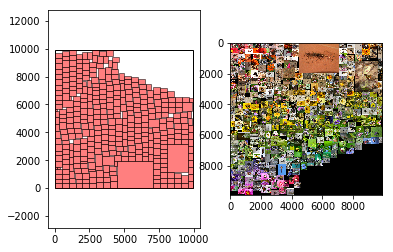

In [7]:
displaybin(repack, dims, files)

In [8]:
%%time
b = pb.Binnit(0,0) # initialize best fit
pack = b.Pack(sizelist, heuristic=1, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: MaxRectsBinPack, heuristic: RectBestLongSideFit
CPU times: user 19.2 ms, sys: 20.6 ms, total: 39.8 ms
Wall time: 13.2 ms


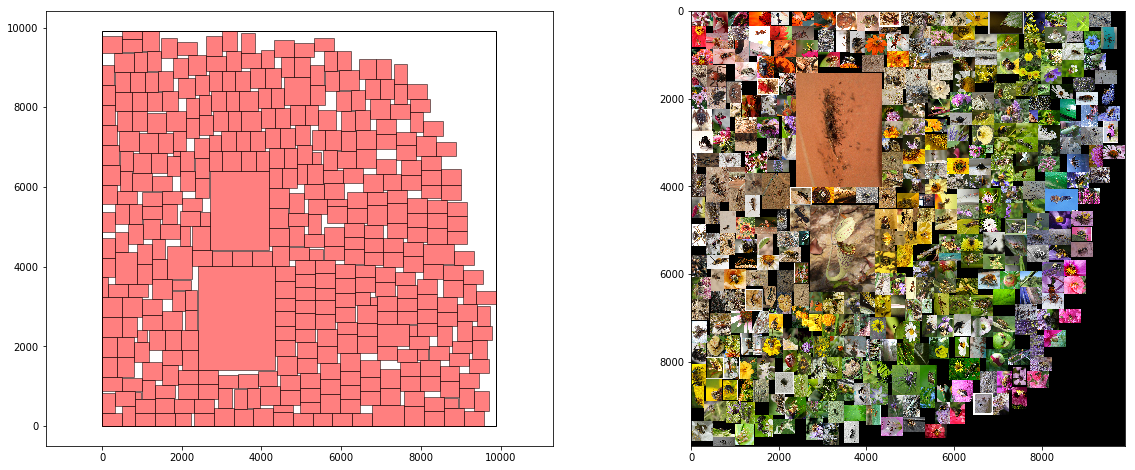

In [9]:
displaybin(repack, dims, files, figsize=(15,5))

In [10]:
%%time
b = pb.Binnit(0,0) # initialize best fit
pack = b.Pack(sizelist, heuristic=2, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: MaxRectsBinPack, heuristic: RectBestAreaFit
CPU times: user 4.63 ms, sys: 101 µs, total: 4.74 ms
Wall time: 4.51 ms


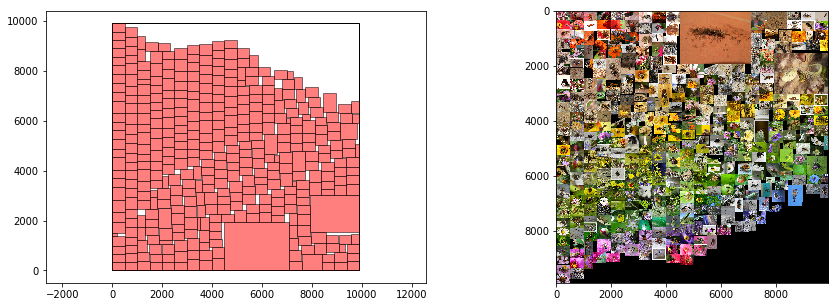

In [11]:
displaybin(repack, dims, files, figsize=(15,5))

In [12]:
%%time
b = pb.Binnit(0,0) # initialize best fit
pack = b.Pack(sizelist, heuristic=3, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: MaxRectsBinPack, heuristic: RectBottomLeftRule
CPU times: user 7.39 ms, sys: 0 ns, total: 7.39 ms
Wall time: 7.12 ms


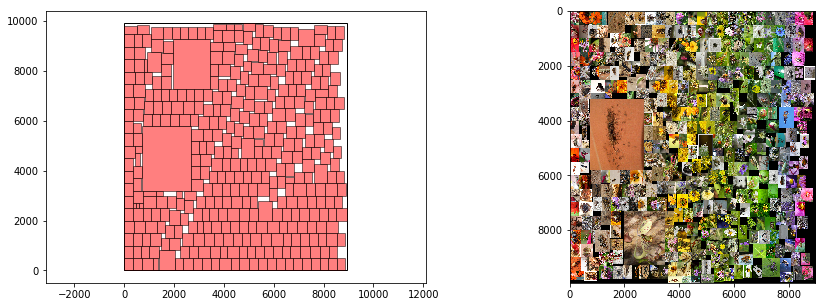

In [13]:
displaybin(repack, dims, files, figsize=(15,5))

In [14]:
%%time
b = pb.Binnit(0,0) # initialize best fit
pack = b.Pack(sizelist, heuristic=4, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: MaxRectsBinPack, heuristic: RectContactPointRule
CPU times: user 18.6 ms, sys: 396 µs, total: 19 ms
Wall time: 18.8 ms


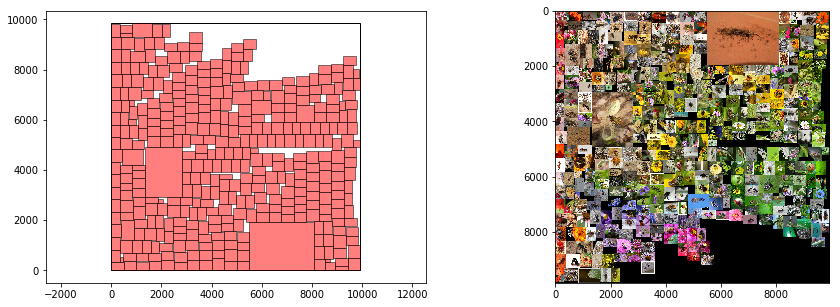

In [15]:
displaybin(repack, dims, files, figsize=(15,5))

### GuillotineBinPack

6 heuristics:
* RectBestAreaFit
* RectBestShortSideFit
* RectBestLongSideFit
* RectWorstAreaFit
* RectWorstShortSideFit
* RectWorstLongSideFit

6 split algorithms -  only ran the the split algoriths with the first heuristic
* SplitShorterLeftoverAxis
* SplitLongerLeftoverAxis
* SplitMinimizeArea
* SplitMaximizeArea
* SplitShorterAxis
* SplitLongerAxis

In [16]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=1, heuristic=0, split_method=0, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: GuillotineBinPack, heuristic: RectBestAreaFit , split method: SplitShorterLeftoverAxis
CPU times: user 4.31 ms, sys: 46 µs, total: 4.35 ms
Wall time: 4.29 ms


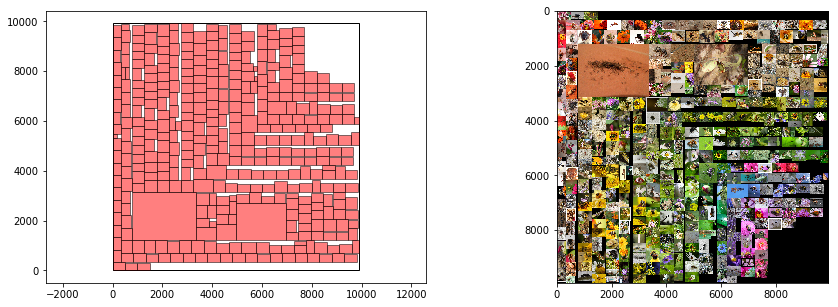

In [17]:
displaybin(repack, dims, files, figsize=(15,5))

In [18]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=1, heuristic=0, split_method=1, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: GuillotineBinPack, heuristic: RectBestAreaFit , split method: SplitLongerLeftoverAxis
Number of rectangles that dont fit: 110
CPU times: user 1.44 ms, sys: 217 µs, total: 1.65 ms
Wall time: 1.56 ms


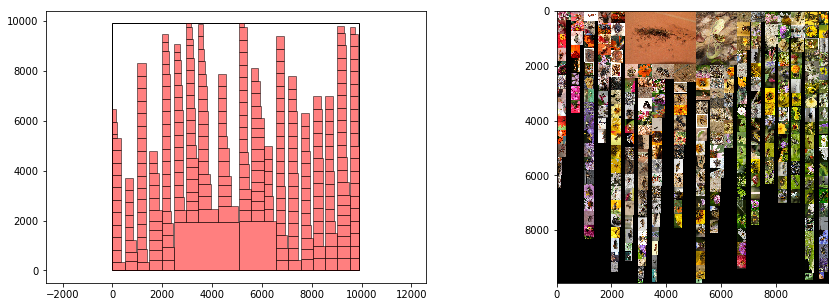

In [19]:
displaybin(repack, dims, files, figsize=(15,5))

In [20]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=1, heuristic=0, split_method=2, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: GuillotineBinPack, heuristic: RectBestAreaFit , split method: SplitMinimizeArea
CPU times: user 6.11 ms, sys: 321 µs, total: 6.43 ms
Wall time: 6.22 ms


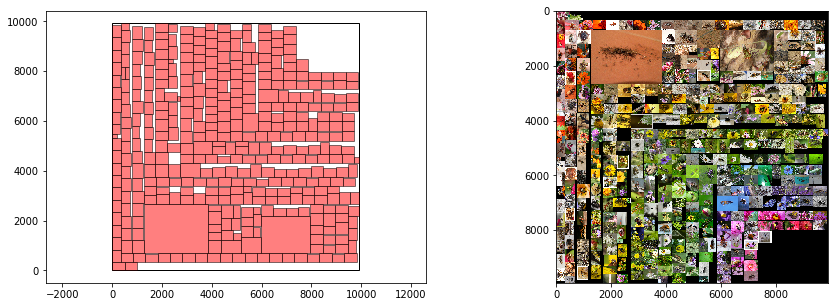

In [21]:
displaybin(repack, dims, files, figsize=(15,5))

In [22]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=1, heuristic=0, split_method=3, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: GuillotineBinPack, heuristic: RectBestAreaFit , split method: SplitMaximizeArea
Number of rectangles that dont fit: 110
CPU times: user 0 ns, sys: 1.91 ms, total: 1.91 ms
Wall time: 1.79 ms


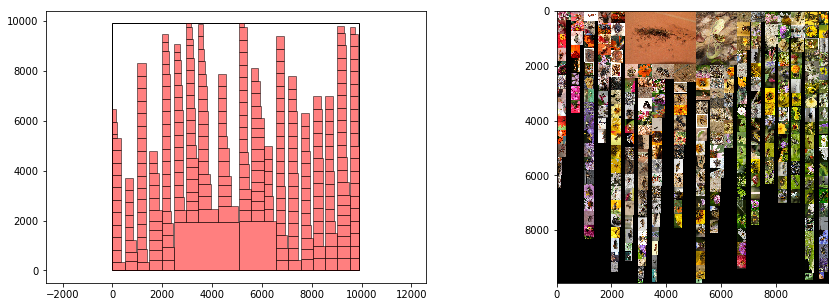

In [23]:
displaybin(repack, dims, files, figsize=(15,5))

In [24]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=1, heuristic=0, split_method=4, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: GuillotineBinPack, heuristic: RectBestAreaFit , split method: SplitShorterAxis
CPU times: user 4.92 ms, sys: 141 µs, total: 5.06 ms
Wall time: 4.97 ms


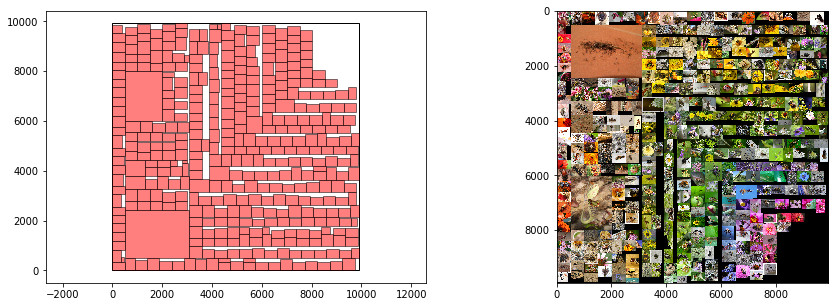

In [25]:
displaybin(repack, dims, files, figsize=(15,5))

In [26]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=1, heuristic=0, split_method=5, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: GuillotineBinPack, heuristic: RectBestAreaFit , split method: SplitLongerAxis
Number of rectangles that dont fit: 115
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.86 ms


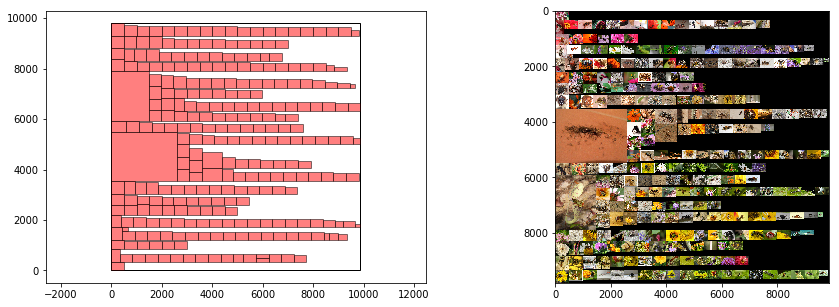

In [27]:
displaybin(repack, dims, files, figsize=(15,5))

In [28]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=1, heuristic=1, split_method=0, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: GuillotineBinPack, heuristic: RectBestShortSideFit , split method: SplitShorterLeftoverAxis
CPU times: user 2.81 ms, sys: 0 ns, total: 2.81 ms
Wall time: 2.82 ms


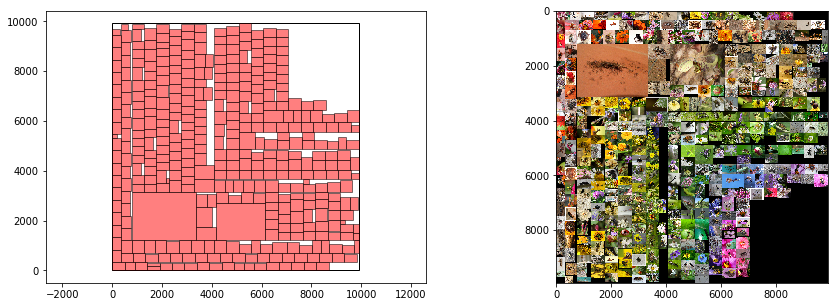

In [29]:
displaybin(repack, dims, files, figsize=(15,5))

In [30]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=1, heuristic=2, split_method=0, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: GuillotineBinPack, heuristic: RectBestLongSideFit , split method: SplitShorterLeftoverAxis
Number of rectangles that dont fit: 9
CPU times: user 5.29 ms, sys: 202 µs, total: 5.49 ms
Wall time: 5.22 ms


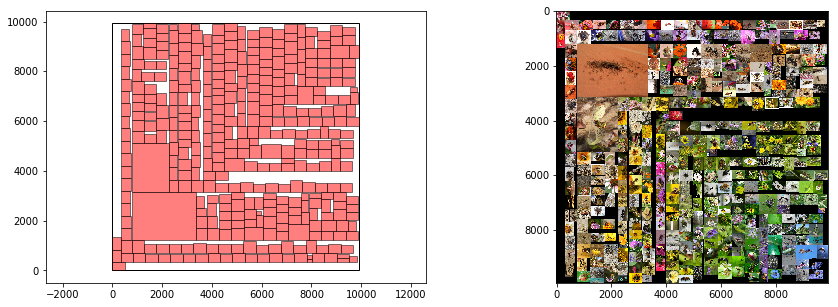

In [31]:
displaybin(repack, dims, files, figsize=(15,5))

In [32]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=1, heuristic=3, split_method=0, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: GuillotineBinPack, heuristic: RectWorstAreaFit , split method: SplitShorterLeftoverAxis
Number of rectangles that dont fit: 1
CPU times: user 4.28 ms, sys: 44 µs, total: 4.33 ms
Wall time: 4.16 ms


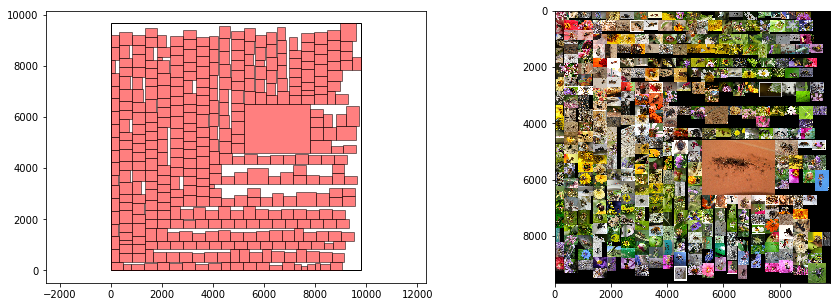

In [33]:
displaybin(repack, dims, files, figsize=(15,5))

In [34]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=1, heuristic=4, split_method=0, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: GuillotineBinPack, heuristic: RectWorstShortSideFit , split method: SplitShorterLeftoverAxis
Number of rectangles that dont fit: 5
CPU times: user 6.38 ms, sys: 0 ns, total: 6.38 ms
Wall time: 6.2 ms


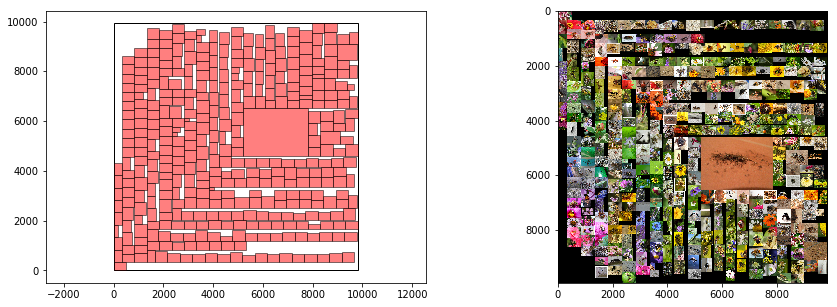

In [35]:
displaybin(repack, dims, files, figsize=(15,5))

In [36]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=1, heuristic=5, split_method=0, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: GuillotineBinPack, heuristic: RectWorstLongSideFit , split method: SplitShorterLeftoverAxis
CPU times: user 4.26 ms, sys: 41 µs, total: 4.3 ms
Wall time: 4.15 ms


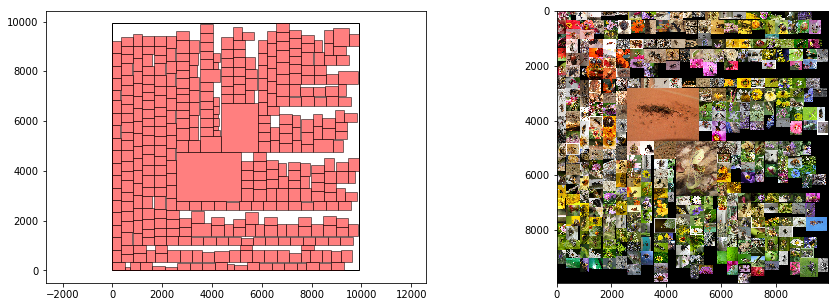

In [37]:
displaybin(repack, dims, files, figsize=(15,5))

### ShelfBinPack
** Errata it it does not seem that new shelves are initialized?** : all huristics look the same same, perhaps Im not doing something with the bins. 

In [38]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=2, heuristic=0, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: ShelfBinPack, heuristic: ShelfNextFit
Number of rectangles that dont fit: 20
CPU times: user 1.27 ms, sys: 200 µs, total: 1.47 ms
Wall time: 1.34 ms


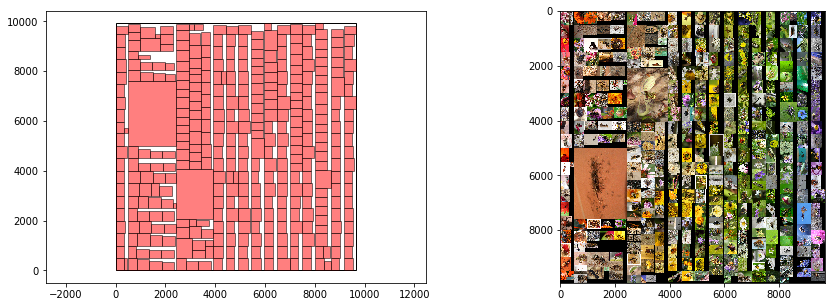

In [39]:
displaybin(repack, dims, files, figsize=(15,5))

In [40]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=2, heuristic=1, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: ShelfBinPack, heuristic: ShelfFirstFit
Number of rectangles that dont fit: 20
CPU times: user 1.33 ms, sys: 209 µs, total: 1.54 ms
Wall time: 1.43 ms


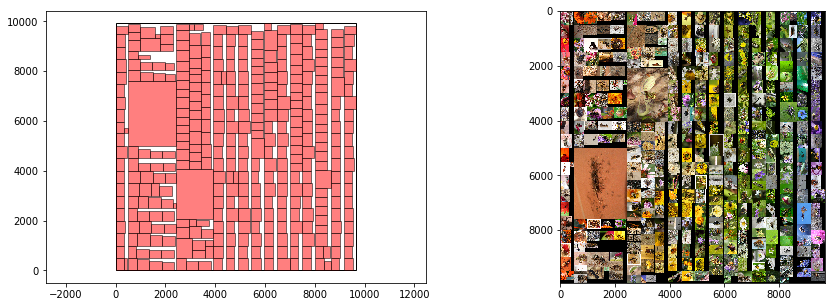

In [41]:
displaybin(repack, dims, files, figsize=(15,5))

### ShelfNextBinpack
* no heurisics

** does not look to efficient for datasets with wildly varying image sizes.**

In [42]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=3, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: ShelfNextFitBinPack
Number of rectangles that dont fit: 89
CPU times: user 310 µs, sys: 49 µs, total: 359 µs
Wall time: 305 µs


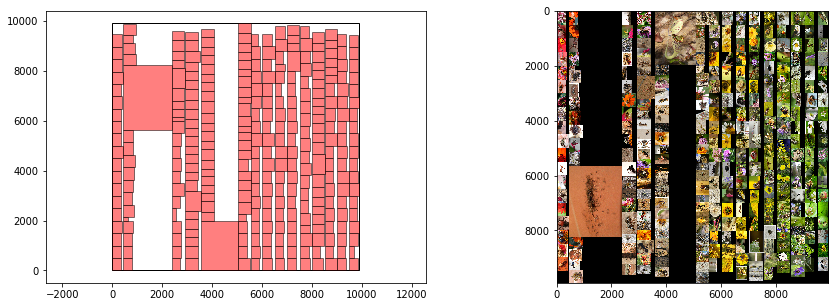

In [43]:
displaybin(repack, dims, files, figsize=(15,5))

### SkylineBinPack
2 heuristics
* LevelBottomLeft
* LevelMinWasteFit

In [44]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=4, heuristic=0, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: SkylineBinPack, heuristic: LevelBottomLeft
CPU times: user 2.25 ms, sys: 356 µs, total: 2.61 ms
Wall time: 2.55 ms


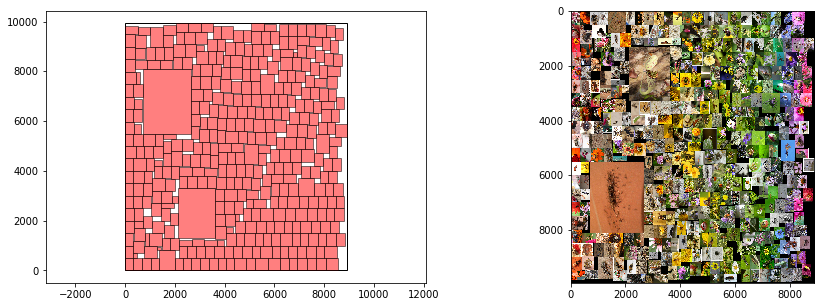

In [45]:
displaybin(repack, dims, files, figsize=(15,5))

In [46]:
%%time
b = pb.Binnit(0,0) # initialize best fit-
pack = b.Pack(sizelist, method=4, heuristic=1, verbose=True)
repack, dims = pack_to_canvas(pack)

array has  397  elements, of  2 dimensions
chosen method: SkylineBinPack, heuristic: LevelMinWasteFit
CPU times: user 1.19 ms, sys: 188 µs, total: 1.38 ms
Wall time: 1.27 ms


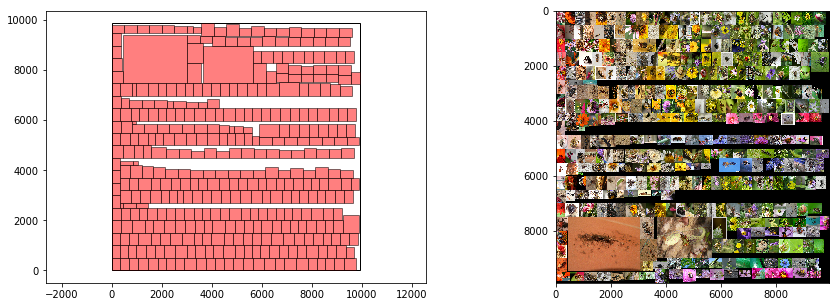

In [47]:
displaybin(repack, dims, files, figsize=(15,5))